In [1]:
!conda install -y gdown

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.0.12            |     pyh9f0ad1d_0          10 KB  conda-forge
    gdown-3.12.2               |     pyh9f0ad1d_0          12 KB  conda-forge
    openssl-1.1.1j             |       h7f98852_0         2.1 MB  conda-forge
    ------------------------------------

In [2]:
!gdown --id 1-pS3qEmU0ogZc4qGNPC54ool0CGLzp27

Downloading...
From: https://drive.google.com/uc?id=1-pS3qEmU0ogZc4qGNPC54ool0CGLzp27
To: /kaggle/working/model_state_epoch_016.pth
305MB [00:01, 160MB/s]


In [3]:
!pip install -qq ensemble_boxes
!pip install -qq imagesize

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import *
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from ensemble_boxes import *
import imagesize

In [5]:
config = {
    'num_classes':15,
    'num_queries': 100,
    
    'skip_box_thr': 0.0,
    'iou_thr': 0.75,
    'imgSize': 800,
    'edge_thr': 10,
    'WEIGHT_PATH': glob('*.pth')[0],
    'device': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
}

In [6]:
def get_valid_transforms():
    return A.Compose([
        A.Resize(height=config['imgSize'], width=config['imgSize'], p=1),
        ToTensorV2(p=1.0),
        ], p=1.0)

In [7]:
class DatasetRetriever(Dataset):
    def __init__(self, image_dir, image_ids, transforms=None):
        super().__init__()
        self.image_dir = image_dir
        self.image_ids = image_ids
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [8]:
dataset = DatasetRetriever(image_dir = '../input/vinbigdata-original-image-dataset/vinbigdata/test',
                           image_ids = np.array([image_id.split('/')[-1].split('.')[0] for image_id in glob(os.path.join('../input/vinbigdata-original-image-dataset/vinbigdata/test', "*.jpg"))]), 
                           transforms = get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, drop_last=False, collate_fn=collate_fn)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone = resnet_fpn_backbone('resnet152', True)
net = FasterRCNN(backbone, config['num_classes'], box_nms_thresh=0.15, box_score_thresh=0.0, box_detections_per_img=500)
net.load_state_dict(torch.load(config['WEIGHT_PATH'], map_location=config['device']))
net.eval()
net = net.to(config['device'])

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [10]:
def make_predictions(images, score_threshold=0.5):
    images = list(image.to(config['device']) for image in images)
    predictions = []
    with torch.no_grad():
        det = net(images)
        for i in range(len(images)):
            _, h,w = images[i].cpu().detach().numpy().shape
            
            boxes = det[i]['boxes'].detach().cpu().numpy()
            scores = det[i]['scores'].detach().cpu().numpy()
            labels = det[i]['labels'].detach().cpu().numpy()
            
            
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(labels < 15)[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,0] > 0+config['edge_thr'])[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,1] > 0+config['edge_thr'])[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,2] < w-config['edge_thr'])[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            indexes = np.where(boxes[:,3] < h-config['edge_thr'])[0]
            boxes = boxes[indexes]
            scores = scores[indexes]
            labels = labels[indexes]
            
            
            boxes[:, 0] = (boxes[:, 0] / w)
            boxes[:, 1] = (boxes[:, 1] / h)
            boxes[:, 2] = (boxes[:, 2] / w)
            boxes[:, 3] = (boxes[:, 3] / h)
            
            predictions.append({
                'boxes': boxes,
                'scores': scores,
                'labels': labels.astype(np.int32)-1
            })
    return predictions

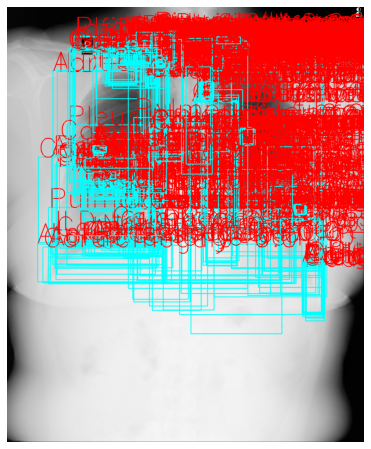

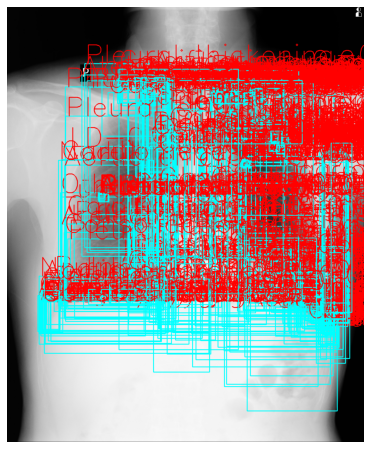

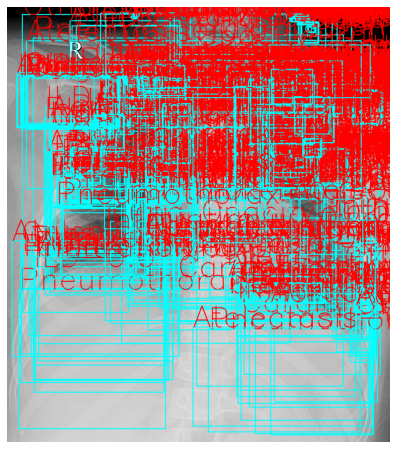

In [11]:
mapping = {0: 'Aortic enlargement', 1: 'Atelectasis', 2: 'Calcification', 3: 'Cardiomegaly', 4: 'Consolidation', 5: 'ILD',6: 'Infiltration', 7: 'Lung Opacity', 
           8: 'Nodule/Mass', 9: 'Other lesion', 10: 'Pleural effusion', 11: 'Pleural thickening',12: 'Pneumothorax', 13: 'Pulmonary fibrosis', 14: 'No finding'}

for j, (images, image_ids) in enumerate(data_loader):
    predictions = make_predictions(images, score_threshold=config['skip_box_thr'])
    for i in range(len(predictions)):
        prediction = predictions[i]
        image_id = image_ids[i]
        
        if (len(prediction['scores'])>0):
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            
            image = cv2.imread(f'../input/vinbigdata-original-image-dataset/vinbigdata/test/{image_id}.jpg', cv2.IMREAD_COLOR).copy().astype(np.float32)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.0
            h,w,_ = image.shape
            
            boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
            boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], 
                                                          weights=None, 
                                                          iou_thr=config['iou_thr'],
                                                          skip_box_thr=config['skip_box_thr'])
            
    
            boxes[:, 0] = (boxes[:, 0] * w)
            boxes[:, 1] = (boxes[:, 1] * h)
            boxes[:, 2] = (boxes[:, 2] * w)
            boxes[:, 3] = (boxes[:, 3] * h)
        
            boxes = boxes.astype(np.int32)
            for score, box, label in zip(scores, boxes, labels):
                cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 1, 1), 3)
                cv2.putText(image, mapping[label] + "-" + str(round(score, 2)), (box[0], box[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 5, (1, 0, 0), 3, cv2.LINE_AA)

            ax.set_axis_off()
            ax.imshow(image)
            plt.show()
    if j >= 2:
        break

In [12]:
df = {'image_id': [],
      'class_id': [],
      'score':[],
      'x_min': [],
      'x_max': [],
      'y_min': [],
      'y_max': []}
for images, image_ids in tqdm(data_loader):
    predictions = make_predictions(images, score_threshold=config['skip_box_thr'])
    
    for i in range(len(predictions)):
        prediction = predictions[i]
        image_id = image_ids[i]
        w, h = imagesize.get(f'../input/vinbigdata-original-image-dataset/vinbigdata/test/{image_id}.jpg')
        
        boxes, scores, labels = prediction['boxes'], prediction['scores'], prediction['labels']
        
        '''
        boxes, scores, labels = weighted_boxes_fusion([boxes], [scores], [labels], 
                                                          weights=None, 
                                                          iou_thr=config['iou_thr'],
                                                          skip_box_thr=config['skip_box_thr'])
        '''
        
        df['image_id'] += [image_id]*len(labels)
        df['class_id'] += labels.tolist()
        df['score'] += scores.tolist()
        df['x_min'] += boxes[:, 0].tolist()
        df['y_min'] += boxes[:, 1].tolist()
        df['x_max'] += boxes[:, 2].tolist()
        df['y_max'] += boxes[:, 3].tolist()

100%|██████████| 3000/3000 [09:18<00:00,  5.37it/s]


In [13]:
import pandas as pd
from tqdm import *
def to_submission(df, sample_file='sample_submission.csv', filename=None, trick=True):
    '''
    df: output dataframe
    sample_file: sample_submission file (to get image_id)
    filename: to csv file name
    trick: add class 14 to all images
    
    return a dataframe
    '''
    
    ss = pd.read_csv(sample_file)
    d = {i:[] for i in ss['image_id'].values.tolist()}
    sizemap = {i:(w,h) for i,w,h in zip(ss['image_id'].values.tolist(), ss['width'].values.tolist(), ss['height'].values.tolist())}
    trick_string = {i:'14 '+str(s)+' 0 0 1 1' for i,s in zip(ss['image_id'].values.tolist(), ss['class14prob'].values.tolist())}
    
    image_id = []
    PredictionString = []
    for i in trange(len(df['image_id'].values.tolist())):
        w,h = sizemap[df['image_id'][i]]
        d[df['image_id'][i]].append(" ".join(map(str, [int(df['class_id'][i]), df['score'][i], round(float(df['x_min'][i])*w), round(float(df['y_min'][i])*h), round(float(df['x_max'][i])*w), round(float(df['y_max'][i])*h)] )))
        
    for (k,v) in d.items():
        image_id.append(k)
        if (len(v) == 0): #case 14 1 0 0 1 1 not in df
            PredictionString.append(trick_string[k])
        elif (len(v) == 1 and v[0].startswith("14 ")): #case 14 x 0 0 1 1 in df
            PredictionString.append(" ".join(v[0].split()[:2])+' 0 0 1 1')
        else:
            if trick:
                v.append(trick_string[k])
            PredictionString.append(" ".join(v))
    result = pd.DataFrame()
    result['image_id'] = image_id
    result['PredictionString'] = PredictionString
    
    result.sort_values('image_id', ignore_index=True,  inplace=True)
    
    if (filename):
        result.to_csv(filename, index = False)
    return result

In [14]:
submission = to_submission(pd.DataFrame().from_dict(df), 
                           sample_file = '../input/2021-vin-mydataset/test.csv',
                           filename='submission.csv'
                          )
submission.head(10)

100%|██████████| 1388755/1388755 [01:31<00:00, 15191.85it/s]


,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,3 0.8384832143783569 818 1218 1884 1627 11 0.5...
1,004f33259ee4aef671c2b95d54e4be68,0 0.981261134147644 1248 588 1526 978 11 0.403...
2,008bdde2af2462e86fd373a445d0f4cd,3 0.9840165376663208 1088 1365 1942 1790 0 0.9...
3,009bc039326338823ca3aa84381f17f1,3 0.9592017531394958 675 1002 1551 1378 7 0.42...
4,00a2145de1886cb9eb88869c85d74080,3 0.995430588722229 786 1268 1862 1656 0 0.956...
5,00b7e6bfa4dc1fe9ddd0ce74743e38c2,3 0.8728721141815186 1152 1500 2033 1963 9 0.6...
6,011295e0bcdc7636569ab73bfdcc4450,11 0.7339708209037781 680 483 939 562 11 0.446...
7,013c169f9dad6f1f6485da961b9f7bf2,0 0.9257789254188538 1144 692 1425 1057 13 0.8...
8,01431a2618c0ace741e4e270a37e20b9,3 0.9975168704986572 1068 1460 2039 1775 0 0.9...
9,0168eb925aa6f28a78b16134792f5d0e,0 0.4969906508922577 1307 557 1533 837 9 0.310...
